In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    weight_optimal = (x_init*cur_prices)/(np.dot(x_init, cur_prices)+ cash_init)

    return x_optimal, cash_optimal, weight_optimal

def cash_check(target_units, x_init, target_weight, cash_init, cur_prices):
    
    #calculate cash short fall: (the cash difference between selling and buying all the stocks + commission cost) - initial cash
    #if the number is positive, there's a shortfall. otherwise cash is enough to execute the rebalance
    cash_shortfall = ((np.dot((target_units - x_init), cur_prices) + 
                      (np.dot(np.abs(target_units - x_init), cur_prices)*0.005)) - 
                      cash_init)
    if cash_shortfall > 0:
        #see what's the percentage of the cash shortfall to the current portfolio
        shortfall_pct = cash_shortfall/(np.dot(x_init, cur_prices)+ cash_init)
        #update the target units with leaving out the needed cash from the portfolio  
        updated_target_units = (np.round(target_weight * 
                                         ((np.dot(x_init, cur_prices)+ cash_init)-cash_shortfall)))/cur_prices
        
#         updated_target_units = (np.floor(target_weight * 
#                                          ((np.dot(x_init, cur_prices)+ cash_init)*(1-shortfall_pct))))/cur_prices
        #chekcing the cash shortfall again
        if ((np.dot((updated_target_units - x_init), cur_prices) + 
                      (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005)) - 
                      cash_init) > 0:
            print("Not enough cash to rebalance for Equal Weighted strat. Please check the rebalance function")

    else:
        updated_target_units = target_units
    
    return updated_target_units

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # equally divide portfolio to derive the value for each security
    equal_value = (np.dot(x_init, cur_prices)+ cash_init)/len(x_init)
    # get target weight
    target_weight = np.full((1, len(x_init)), 1/len(x_init))[0]
    # use np.round to make sure the share units are rounded down to integer
    target_units = np.ceil(equal_value/cur_prices) 
    #check if we can cover the rebalance and update weight if needed
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices)
    
    
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
    weight_optimal = target_weight
    
    return x_optimal, cash_optimal, weight_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    # setup coefficients of the objective function, bounds on the variables 
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    # set variable constraint matrix
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    A
    
    var_names = ["w_%s" % i for i in range(1,n+1)]

    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    
    cpx.objective.set_quadratic(Qmat)
    
    cpx.solve()
    
    target_weight = np.array(cpx.solution.get_values())
#     print(target_weight)
    target_units = np.ceil(((np.dot(x_init, cur_prices)+ cash_init) * target_weight)/cur_prices)
#     print(target_units)
    
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices)
    
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
    
    
    weight_optimal = target_weight
    
    return x_optimal, cash_optimal, weight_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #Value of kappa may be greater than 1, thus np.inf is used as bound
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [np.inf] * (n+1)                                   
    #daily risk-free rate
    r_rf = 0.025
    daily_r_rf = (r_rf+1)**(1.0/252)-1 #daily risk-free rate
    alpha = mu - daily_r_rf
    #Add a column and a row of 0 to allow the optimization of kappa
    c_k = np.zeros((n,1))        
    Q1 = np.hstack((Q,c_k))
    c_k = np.zeros((1,n+1))        
    Q2 = np.vstack((Q1,c_k))
    #Append -1 so that the constraint becomes [sum(wi)- kappa = 0]
    A = []
    for k in range(n):
        A.append([[0,1],[alpha[k],1]])
    A.append([[0,1],[0,-1]])                           


    var_names = ["w_%s" % i for i in range(1,n+1+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n+1)), list(2*Q2[k,:])] for k in range(n+1)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    y_opt = np.array(cpx.solution.get_values())                         
    target_weight = y_opt[0:20]/y_opt[20]   
    
    target_units = np.ceil(((np.dot(x_init, cur_prices)+ cash_init) * target_weight)/cur_prices)
    
    updated_target_units = cash_check(target_units, x_init, target_weight, cash_init, cur_prices)
    
    x_optimal = updated_target_units
    cash_optimal = (cash_init + 
                    (-np.dot((updated_target_units - x_init), cur_prices)) -
                    (np.dot(np.abs(updated_target_units - x_init), cur_prices)*0.005))
    weight_optimal = target_weight

    return x_optimal, cash_optimal, weight_optimal


In [3]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'


In [4]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)


In [5]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [6]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [7]:
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [8]:
# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [9]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

In [10]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000012.93



In [11]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [12]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [13]:
# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

In [14]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
# N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

In [15]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, 
                                                                                                       curr_cash, 
                                                                                                       mu, 
                                                                                                       Q, 
                                                                                                       cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990889.18, value end = $ 893211.84
  Strategy "Mininum Variance Portfolio", value begin = $ 992757.86, value end = $ 916381.86
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990083.38, value end = $ 922454.81

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931413.86, value end = $ 862899.20
  Strategy "Mininum Variance Portfolio", value begin = $ 956057.91, value end = $ 851488.40
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962263.66, value end = $ 1017182.20

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
  Strategy "Equally Weighted Portfolio", v

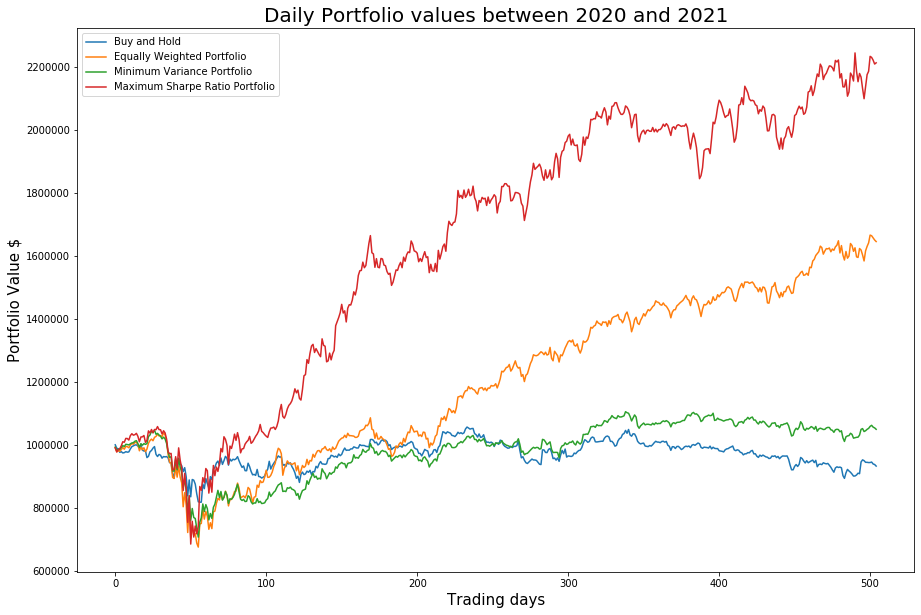

In [16]:
# Plot results
# 1. daily value of portfolio 
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted Portfolio')
plt.plot(portf_value[2], label = 'Minimum Variance Portfolio')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.legend()
plt.ylabel('Portfolio Value $', fontsize=15)
plt.xlabel('Trading days', fontsize=15)
plt.title('Daily Portfolio values between 2020 and 2021', fontsize= 20)
plt.savefig('PVal_2020-2021')
plt.show()

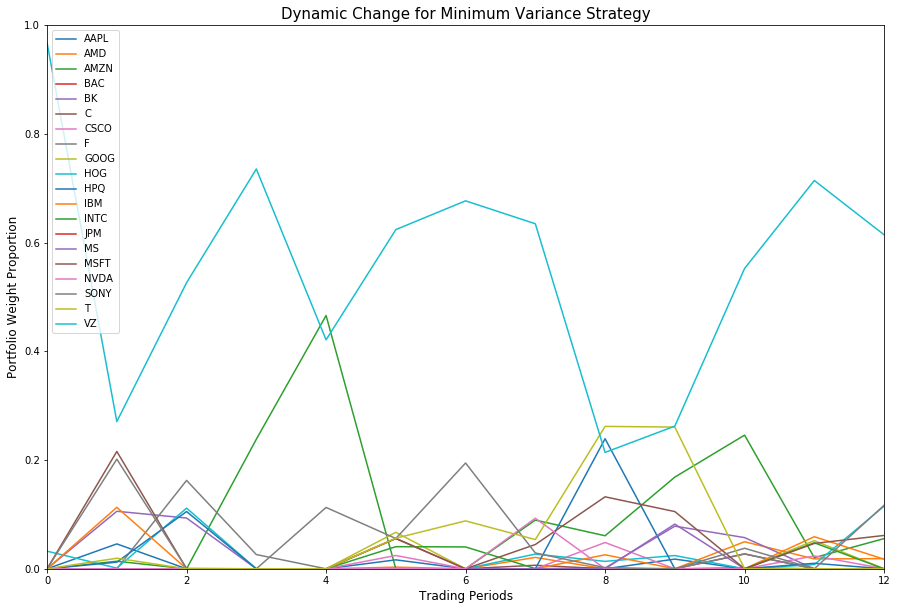

In [17]:
# 2. dynamic change in allocation for strategy 3
df_col = list(df.columns.values)
asset_name = df_col[1:]
init_val = init_positions* data_prices[0, :] #initial $value of each stock 
init_pval = sum(init_val)
w_init = init_val/init_pval
period = np.arange(13)
for i in range(20):
    asset_w = [w_init[i]]
    for j in range(12):
        asset_w.append(weight[2][j][i])        #strategy 3 index 2
    plt.plot(period, asset_w, label = asset_name[i])
plt.legend()
plt.xlim([0,12])
plt.ylim([0,1])
plt.xlabel('Trading Periods', fontsize=12)
plt.ylabel('Portfolio Weight Proportion',fontsize=12)
plt.title('Dynamic Change for Minimum Variance Strategy',fontsize=15)
plt.savefig('Min_Var_Change_fig')

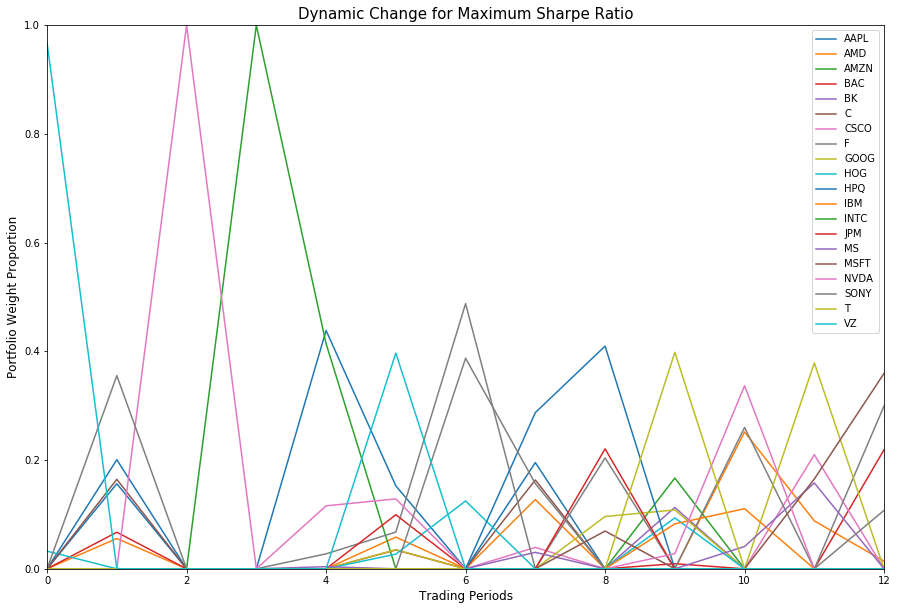

In [18]:
#Dynamic Change for Strategy Max Sharpe Ratio
for i in range(20):
    asset_w = [w_init[i]]
    for j in range(12):
        asset_w.append(weight[3][j][i])        #strategy 3 index 2
    plt.plot(period, asset_w, label = asset_name[i])
plt.legend()
plt.xlim([0,12])
plt.ylim([0,1])
plt.xlabel('Trading Periods', fontsize=12)
plt.ylabel('Portfolio Weight Proportion',fontsize=12)
plt.title('Dynamic Change for Maximum Sharpe Ratio',fontsize=15)
plt.savefig('Max_Sharpe_Change_fig')

In [19]:
df_result = pd.DataFrame(np.round(portf_value[0], 2), columns = ['Buy and Hold'])
df_result['Equally Weighted Portfolio'] = np.round(portf_value[1], 2)
df_result['Minimum Variance Portfolio'] = np.round(portf_value[2], 2)
df_result['Maximum Sharpe Ratio Portfolio'] = np.round(portf_value[3], 2)

In [20]:
df_result['Buy and Hold daily returns'] = df_result['Buy and Hold'].pct_change()
df_result['Equally Weighted Portfolio daily returns'] = df_result['Equally Weighted Portfolio'].pct_change()
df_result['Minimum Variance Portfolio daily returns'] = df_result['Minimum Variance Portfolio'].pct_change()
df_result['Maximum Sharpe Ratio Portfolio daily returns'] = df_result['Maximum Sharpe Ratio Portfolio'].pct_change()

In [21]:
df_result['Buy and Hold cumulative_returns'] = (1 + df_result['Buy and Hold daily returns']).cumprod() - 1
df_result['Equally Weighted cumulative_returns'] = (1 + df_result['Equally Weighted Portfolio daily returns']).cumprod() - 1
df_result['Minimum Variance cumulative_returns'] = (1 + df_result['Minimum Variance Portfolio daily returns']).cumprod() - 1
df_result['Maximum Sharpe Ratio cumulative_returns'] = (1 + df_result['Maximum Sharpe Ratio Portfolio daily returns']).cumprod() - 1

In [22]:
df_result

,Buy and Hold,Equally Weighted Portfolio,Minimum Variance Portfolio,Maximum Sharpe Ratio Portfolio,Buy and Hold daily returns,Equally Weighted Portfolio daily returns,Minimum Variance Portfolio daily returns,Maximum Sharpe Ratio Portfolio daily returns,Buy and Hold cumulative_returns,Equally Weighted cumulative_returns,Minimum Variance cumulative_returns,Maximum Sharpe Ratio cumulative_returns
0,1000012.93,990889.18,992757.86,990083.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,989002.73,978044.23,981497.30,977303.26,-0.011010,-0.012963,-0.011343,-0.012908,-0.011010,-0.012963,-0.011343,-0.012908
2,987178.54,981435.64,985851.83,984768.14,-0.001844,0.003468,0.004437,0.007638,-0.012834,-0.009540,-0.006956,-0.005368
3,976096.14,979330.04,985157.20,987690.09,-0.011226,-0.002145,-0.000705,0.002967,-0.023916,-0.011665,-0.007656,-0.002417
4,978285.81,984692.13,991627.17,996890.33,0.002243,0.005475,0.006567,0.009315,-0.021727,-0.006254,-0.001139,0.006875
...,...,...,...,...,...,...,...,...,...,...,...,...
500,943757.79,1665591.25,1058451.27,2232945.61,0.000153,0.015083,0.006038,0.021746,-0.056254,0.680906,0.066173,1.255311
501,945207.14,1663558.65,1061854.37,2229577.51,0.001536,-0.001220,0.003215,-0.001508,-0.054805,0.678854,0.069601,1.251909
502,939108.44,1656788.90,1056070.04,2220838.33,-0.006452,-0.004069,-0.005447,-0.003920,-0.060904,0.672022,0.063774,1.243082
503,937449.87,1650025.43,1053661.66,2208490.22,-0.001766,-0.004082,-0.002281,-0.005560,-0.062562,0.665197,0.061348,1.230610


In [23]:
#risk free asset cum return 
((r_rf+1)**2)-1

0.05062499999999992